#**YOLO v1 from Scratch**

####Getting the Data

In [ ]:
!pip install opendatasets --q
import opendatasets as od
od.download('https://www.kaggle.com/datasets/aladdinpersson/pascalvoc-yolo', data_dir='YOLOv1_Dataset')

Skipping, found downloaded files in "YOLOv1_Dataset/pascalvoc-yolo" (use force=True to force download)


###Libraries

In [ ]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms

import torch.nn.functional as F
import torchvision.transforms.functional as FT

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
from tqdm.auto import tqdm

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image

import matplotlib.patches as patches

import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.manual_seed(2)

##Utils

---

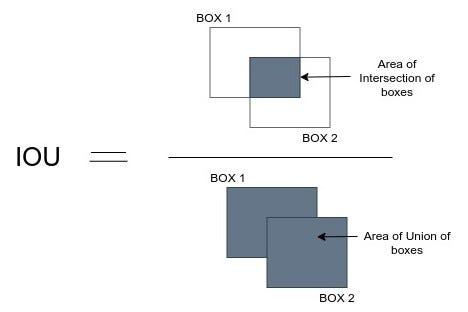

In [ ]:
# @title Calculationg IOU
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2 # we do [n : n+1] so that the dimensions are kept the same
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

---

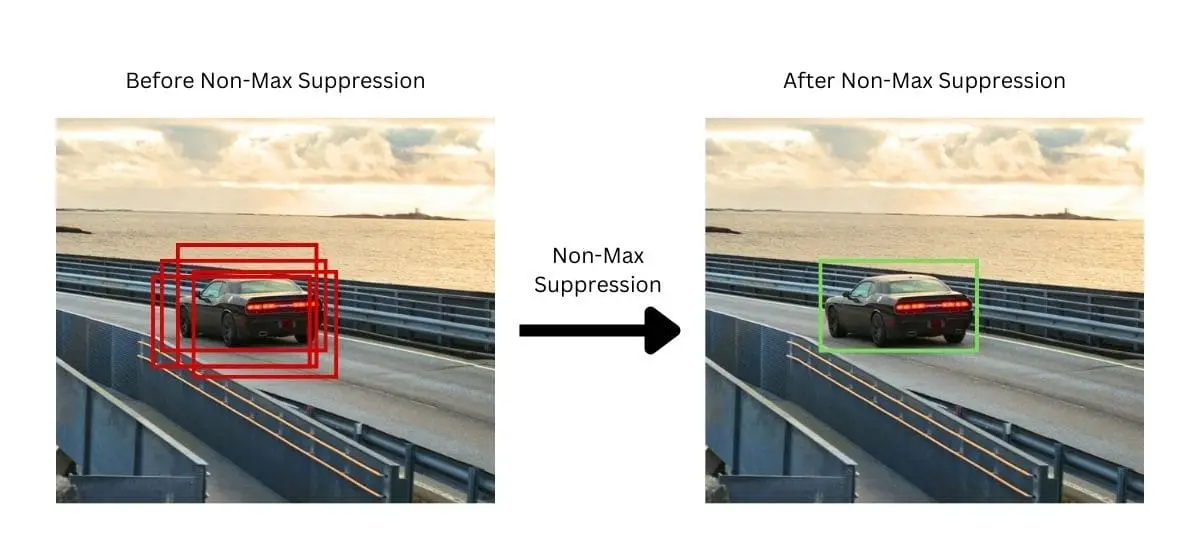

In [ ]:
# @title Non-Max Superssion
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="midpoint"):

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if torch.sigmoid(torch.tensor(box[1])).item() > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

---

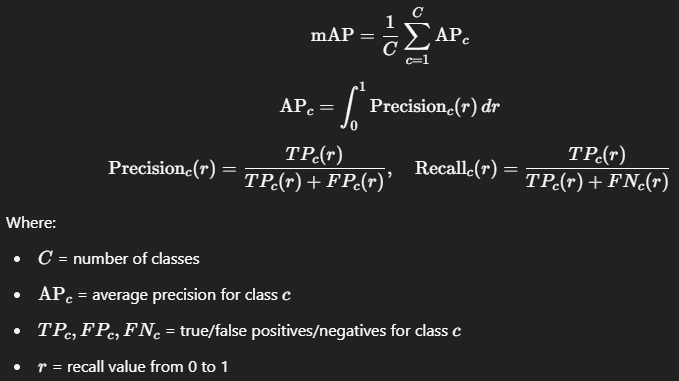

In [ ]:
# @title Calculating mAP
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
          amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

---

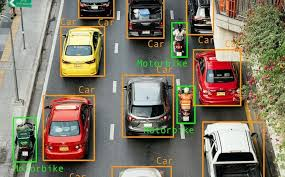

In [ ]:
# @title Bounding Boxes cordinates relative to Grid Cell --> Bounding Boxes cordinates relative to Image
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [ ]:
# @title Convert Grid Cell Predictions to Per-Image Bounding Box Lists
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [ ]:
# @title Extract and Postprocess Bounding Boxes from a DataLoader Using
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [ ]:
# @title Plot Predicted Bounding Boxes on the Image
def plot_image(image, boxes, class_names=None):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    color_map = plt.get_cmap('tab20')

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        bbox_class_id = int(box[0])#for visualization
        confidence_score = torch.sigmoid(torch.tensor(box[1])).item()#for visualization

        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        x_center, y_center, w, h = box

        x1 = x_center - w / 2
        y1 = y_center - h / 2
        x2 = x_center + w / 2
        y2 = y_center + h / 2

        # Clamp all corners to [0, 1]
        x1 = max(0.0, x1)
        y1 = max(0.0, y1)
        x2 = min(1.0, x2)
        y2 = min(1.0, y2)

        w = x2 - x1
        h = y2 - y1

        color = color_map(bbox_class_id % 20) #we already have 20 lasses but we will do this just for safety

        rect = patches.Rectangle(
            (x1 * width, y1 * height),
            w * width,
            h * height,
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        bbox_text_label = f'{class_names[bbox_class_id] if class_names else bbox_class_id}: {confidence_score:.2f}'

        ax.text(
            x1 * width, y1 * height,
            bbox_text_label,
            fontsize=6,
            color='white',
            verticalalignment='top',
            bbox={
                'facecolor': color,
                'alpha': 0.6,
                'pad': 1,
                'edgecolor': 'none'
            }
        )

    plt.axis('off')

    plt.show()

---

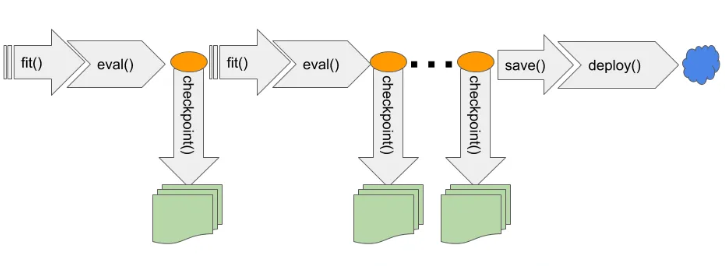

In [ ]:
# @title Saving and Loading the Checkpoints
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

---

#Architecture

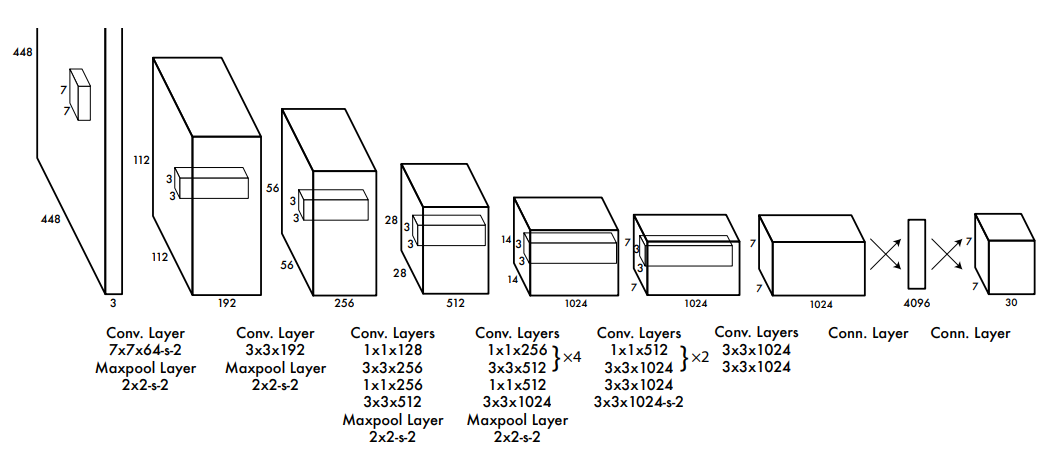

In [ ]:
architecture_config = [
    #Tuple: (kernel_size, num_filters, stride, padding)
    (7, 64, 2, 3),
    'M',

    (3, 192, 1, 1),
    'M',

    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    'M',

    #List: Tuple(kernel_size, num_filters, stride, padding), Int(How many times to repeat),
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    'M',

    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),

    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [ ]:
class CNN_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super().__init__()

    self.Conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          bias=False, #because we will use BN that by removing the mean removes the bias (THE BN ISN'T APPLIED IN THE ORIGINAL IMPLEMENTATION)
                          **kwargs)

    self.BN = nn.BatchNorm2d(out_channels)


  def forward(self, X):
    out = self.Conv(X)
    out = self.BN(out)
    out = F.gelu(out) #ORIGINAL PAPER USED LEAKY RELU

    return out

In [ ]:
class YOLOv1(nn.Module):
  def __init__(self, in_channels=3, arch_config=architecture_config, **kwargs):
   super().__init__()

   self.architecture_config = arch_config
   self.in_channels = in_channels

   self.darknet = self._create_conv_layers(self.architecture_config)

   self.fc = self._create_fcs(**kwargs)


  def _create_conv_layers(self, architecture_config):
    layers = []

    in_channels = self.in_channels

    for layer in architecture_config:
      if type(layer) == tuple:
        layers += [CNN_block(in_channels=in_channels,
                             out_channels=layer[1],
                             kernel_size=layer[0],
                             stride=layer[2],
                             padding=layer[3])]

        in_channels = layer[1]

      elif type(layer) == str:
        layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=2)]

      else:
        conv1 = layer[0]
        conv2 = layer[1]
        num_repeats = layer[2]

        for _ in range(num_repeats):
          layers += [CNN_block(in_channels=in_channels,
                               out_channels=conv1[1],
                               kernel_size=conv1[0],
                               stride=conv1[2],
                               padding=conv1[3])]

          layers += [CNN_block(in_channels=conv1[1],
                               out_channels=conv2[1],
                               kernel_size=conv2[0],
                               stride=conv2[2],
                               padding=conv2[3])]

          in_channels = conv2[1]

    return nn.Sequential(*layers)


  def _create_fcs(self, split_size, num_boxes, num_classes):
    fcs = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024 * split_size * split_size, 2048), #IN THE ORIGINAL PAPER THIS IS 4096 (BUT HTIS TAKES A LOT OF RAM)
        nn.Dropout(0.4), #DIFFERENT VALUE IN THE PAPER
        nn.GELU(),
        nn.Linear(2048, split_size * split_size * (num_classes + 5 * num_boxes))
    )

    return fcs


  def forward(self, X):
    out = self.darknet(X)
    out = torch.flatten(out, start_dim=1)
    out = self.fc(out)

    return out

#Loss

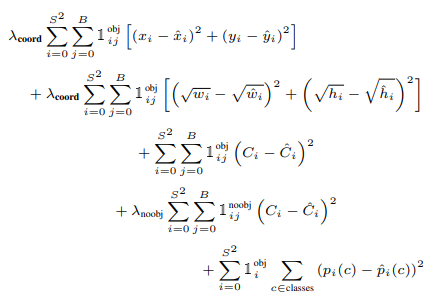

In [ ]:
class YOLO_Loss(nn.Module):
  def __init__(self, split_size=7, num_bboxes=2, num_classes=20):
    super().__init__()

    self.MSE = nn.MSELoss(reduction='sum')

    self.S = split_size
    self.B = num_bboxes
    self.C = num_classes

    self.lambda_noobj = 0.5
    self.lambda_coord = 5

  def forward(self, preds, target):
    preds = preds.reshape(-1, self.S, self.S, self.C + 5 * self.B)

    iou_b1 = intersection_over_union(preds[..., self.C-1+1+1 : self.C-1+1+1+4], #21 : 25
                                     target[..., self.C-1+1+1 : self.C-1+1+1+4])#21 : 25

    iou_b2 = intersection_over_union(preds[..., self.C-1+1+1+5 : self.C-1+1+1+4+5], #26 : 30
                                     target[..., self.C-1+1+1 : self.C-1+1+1+4])#21 : 25

    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

    best_box = torch.argmax(ious, dim=0)


    exists_box = target[..., 20].unsqueeze(3) #confidence score for gt box (for GT box it's either 0 or 1)


    #=========================#
    # LOSS FOR BOX CORDINATES #
    #=========================#

    box_preds = exists_box * (
        (
            best_box * preds[..., 26 : 30] +
            + (1 - best_box) * preds[..., 21 : 25]
        )
      )

    box_targets = exists_box * target[..., 21 : 25]


    box_preds[..., 2 : 4] = torch.sign(box_preds[..., 2:4]) * torch.sqrt(
        torch.abs(box_preds[..., 2 : 4] + 1e-8)
    ) #for box_pred h and w #we add 1e-8 because the gradient of sqrt(...) at 0 is inf

    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2 : 4])

    # (N, S, S, 4) -> (N*S*S, 4) this shape is what MSE expects
    box_loss = self.MSE(
        torch.flatten(box_preds, end_dim=-2),
        torch.flatten(box_targets, end_dim=-2))


    #======================#
    # LOSS FOR OBJECT LOSS #
    #======================#

    pred_box = (
        best_box * preds[..., 25:26] +
        + (1 - best_box) * preds[..., 20:21]
    )

    # (N, S, S, 1) -> (N*S*S, 1)
    object_loss = self.MSE(
        torch.flatten(exists_box * pred_box, start_dim=1),
        torch.flatten(exists_box * target[..., 20:21], start_dim=1))


    #=========================#
    # LOSS FOR NO OBJECT LOSS #
    #=========================#

    # (N, S, S, 1) -> (N*S*S, 1)
    no_object_loss = self.MSE(
        torch.flatten((1 - exists_box) * preds[..., 20:21], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1))

    # calcualte the loss for the 2nd box
    no_object_loss += self.MSE(
        torch.flatten((1 - exists_box) * preds[..., 25:26], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1))


    #=====================#
    # LOSS FOR CLASS LOSS #
    #=====================#

    # (N, S, S, 20) -> (N*S*S, 20)
    class_loss = self.MSE(
        torch.flatten(exists_box * preds[..., :self.C], end_dim=-2),
        torch.flatten(exists_box * target[..., :self.C], end_dim=-2)
    )


    #=====================#
    #        LOSS         #
    #=====================#

    loss = (
        self.lambda_coord * box_loss #first two rows of loss in the paper
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss

#Data Configuration

In [ ]:
class VOC_Dataset(Dataset):
  def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):

    self.annotations = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.transform = transform

    self.S = S      #split_size
    self.B = B      #num_bboxes per grid cell
    self.C = C      #num of classes

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, idx):
    label_path = os.path.join(self.label_dir, self.annotations.iloc[idx, 1])

    boxes = []

    with open(label_path) as f:
      for label in f.readlines():

        class_label, x, y, width, height = [
            float(x) if float(x) != int(float(x)) else int(x)
            for x in label.replace('\n', '').split()
        ]

        boxes.append([class_label, x, y, width, height])

    img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
    image = Image.open(img_path)

    boxes = torch.tensor(boxes)

    if self.transform:
      image, boxes = self.transform(image, boxes)

    label_matrix = torch.zeros((self.S, self.S, self.C + (5 * self.B)))

    for box in boxes:
      class_label, x, y, width, height = box.tolist()
      class_label = int(class_label)

      i, j = int(self.S * y), int(self.S * x)

      x_cell, y_cell = self.S * x - j, self.S * y - i

      width_cell, height_cell = (
          width * self.S,
          height * self.S
      )

      if label_matrix[i, j, 20] == 0:
        label_matrix[i, j, 20] = 1

        box_cordinates = torch.tensor(
            [x_cell, y_cell, width_cell, height_cell]
        )

        label_matrix[i, j, 21:25] = box_cordinates
        label_matrix[i, j, class_label] = 1

    return image, label_matrix

##Data Augmentation

In [ ]:
class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, img, bboxes):
    boxes = bboxes
    for transform in self.transforms:
      try:
        img, boxes = transform(img, bboxes)

      except TypeError:
        img = transform(img)

    return img, boxes

In [ ]:
train_transform = Compose([
    transforms.Resize((448, 448)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

##Creating Train and Test Datasets

In [ ]:
IMG_DIR = '/content/YOLOv1_Dataset/pascalvoc-yolo/images'
LABEL_DIR = '/content/YOLOv1_Dataset/pascalvoc-yolo/labels'

In [ ]:
train_dataset = VOC_Dataset(
    '/content/YOLOv1_Dataset/pascalvoc-yolo/train.csv',
    IMG_DIR,
    LABEL_DIR,
    transform=train_transform
    )

test_dataset = VOC_Dataset(
    '/content/YOLOv1_Dataset/pascalvoc-yolo/test.csv',
    IMG_DIR,
    LABEL_DIR,
    transform=test_transform
    )

##Creating Train and Test Dataloaders

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 2
PIN_MEMORY = True

In [ ]:
train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True
)

test_dl = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
    drop_last=False
)

#Training

In [ ]:
# @title ####Training Hyperparameters

seed = 24
LR = 2e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 12
LOAD_MODEL = False
LOAD_MODEL_FILE = 'YOLOv1.pth'

In [ ]:
CLASS_NAMES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
torch.manual_seed(seed)

In [ ]:
# @title ###Training Function
def train_fn(train_loader, model, optimizer, loss_fn):
  model.train()

  mean_loss = []

  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    mean_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return sum(mean_loss) / len(mean_loss)

In [ ]:
model = YOLOv1(split_size=7, num_boxes=2, num_classes=20).to(device)

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load(LOAD_MODEL_FILE), model. optimizer)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = YOLO_Loss()

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)

In [ ]:
# @title Training Loop
for epoch in tqdm(range(EPOCHS)):

  pred_boxes, target_boxes = get_bboxes(
      train_dl, model, iou_threshold=0.5, threshold=0.4
  )

  mAP = mean_average_precision(
      pred_boxes, target_boxes, iou_threshold=0.5
  )

  if mAP >= 0.6:
    checkpoint = {
        'MODEL_state_dict': model.state_dict(),
        'OPTIMIZER_state_dict': optimizer.state_dict()
    }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
    print(f"\n⚠️ Early stopping: mAP reached {mAP:.2f} at epoch {epoch+1} ⚠️")

    break


  ###########################

  mean_loss = train_fn(train_dl, model, optimizer, loss_fn) #IT TRAINS THE WHOLE MODEL

  lr_scheduler.step()

  print(f'=================\nEpoch: {epoch + 1}\n=================')
  print(f'Train mAP: {mAP:.2f}')
  print(f'Mean Loss is: {mean_loss:.4f}\n')

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1
Train mAP: 0.00
Mean Loss is: 1312.2063

Epoch: 2
Train mAP: 0.00
Mean Loss is: 877.8639

Epoch: 3
Train mAP: 0.00
Mean Loss is: 764.7929

Epoch: 4
Train mAP: 0.01
Mean Loss is: 698.0433

Epoch: 5
Train mAP: 0.01
Mean Loss is: 647.2429

Epoch: 6
Train mAP: 0.01
Mean Loss is: 633.9501

Epoch: 7
Train mAP: 0.01
Mean Loss is: 620.6992

Epoch: 8
Train mAP: 0.01
Mean Loss is: 611.2370

Epoch: 9
Train mAP: 0.02
Mean Loss is: 598.2304

Epoch: 10
Train mAP: 0.02
Mean Loss is: 593.5655

Epoch: 11
Train mAP: 0.02
Mean Loss is: 589.3896

Epoch: 12
Train mAP: 0.02
Mean Loss is: 587.2732



In [ ]:
torch.save({
        'MODEL_state_dict': model.state_dict(),
        'OPTIMIZER_state_dict': optimizer.state_dict()
        }, 'YOLO_V1_state_dict.pth')

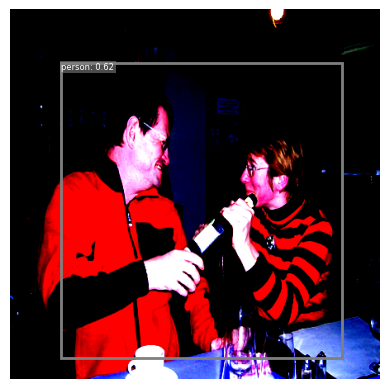

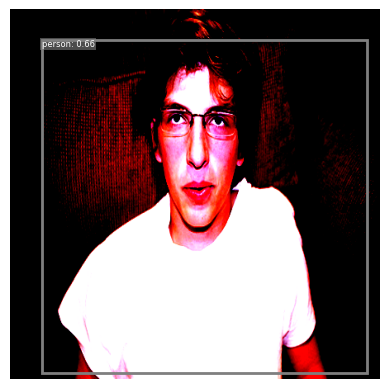

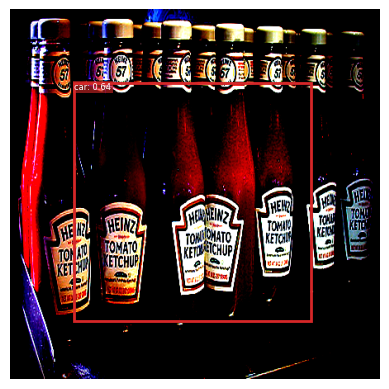

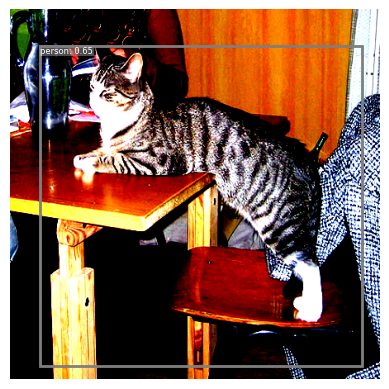

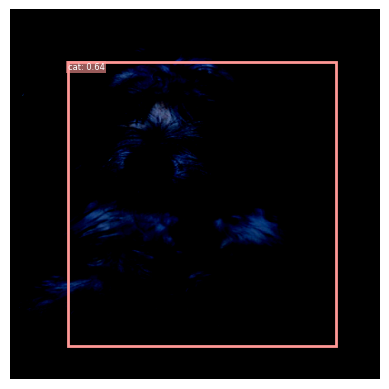

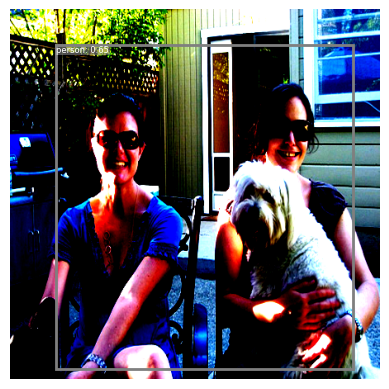

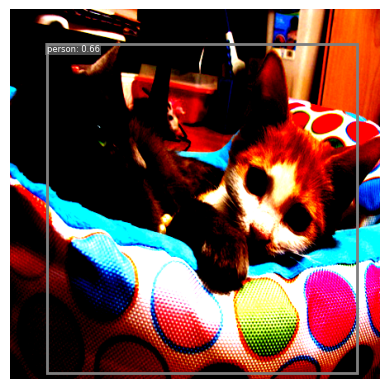

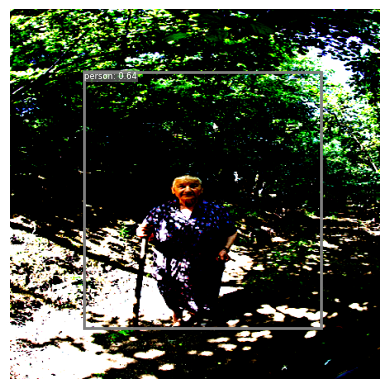

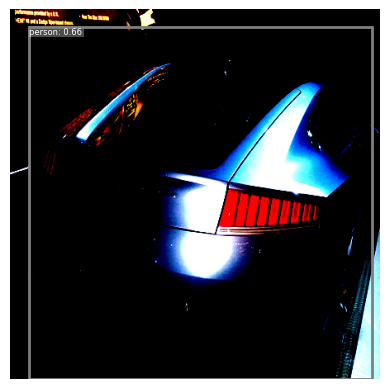

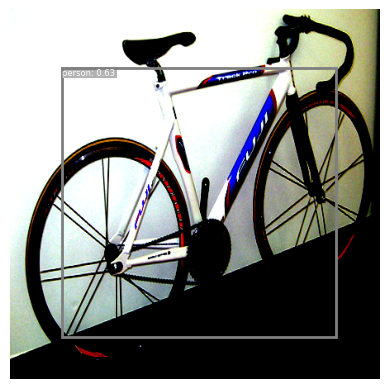

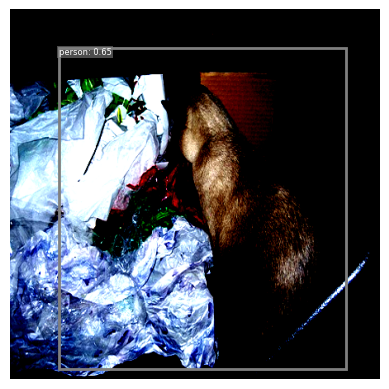

In [ ]:
model.eval()

for num_train_dl, (X, y) in enumerate(train_dl):
    X = X.to(device)
    if num_train_dl % 25 == 0:
      for idx in range(X.size(0)):
        idx = int(random.uniform(0, 64))
        bboxes = cellboxes_to_boxes(model(X))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(X[idx].permute(1,2,0).to("cpu"),
                    bboxes,
                    class_names = CLASS_NAMES)
        break

#Test

In [ ]:
# @title ###Testing Function
def test_fn(test_loader, model, loss_fn):
  model.eval()
  total_loss = 0.0
  n_batches  = 0

  with torch.no_grad():
      for X, y in test_loader:
          X, y = X.to(device), y.to(device)
          preds = model(X)
          total_loss += loss_fn(preds, y).item()
          n_batches += 1

  return total_loss / n_batches

In [ ]:
# @title Test Loop

pred_boxes, target_boxes = get_bboxes(
    test_dl, model, iou_threshold=0.5, threshold=0.4
)

mean_loss = test_fn(test_dl, model, loss_fn) #IT TESTS THE WHOLE MODEL

mAP = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0.5
)

print(f'Test mAP: {mAP:.2f}')
print(f'Mean Loss is: {mean_loss:.4f}\n')

Test mAP: 0.01
Mean Loss is: 536.7080



In [ ]:
model.eval()

for num_test_dl, (X, y) in enumerate(test_dl):
    X = X.to(device)
    if num_test_dl % 5 == 0:
      for idx in range(X.size(0)):
        idx = int(random.uniform(0, 64))
        bboxes = cellboxes_to_boxes(model(X))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.6, box_format="midpoint")
        plot_image(X[idx].permute(1,2,0).to("cpu"),
                    bboxes,
                    class_names = CLASS_NAMES)
        break

OutOfMemoryError: CUDA out of memory. Tried to allocate 294.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 89.38 MiB is free. Process 7186 has 22.06 GiB memory in use. Of the allocated memory 20.84 GiB is allocated by PyTorch, and 1016.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)